In [94]:
# This loads the autoreload extension
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import geopandas as gpd

from my_bbs_anal_funcs import *

# import itables
# itables.init_notebook_mode()
# itables.init_notebook_mode(all_interactive=True)


plt.rcParams['axes.labelsize'] = 14  # Sets default font size for axis labels
plt.rcParams['xtick.labelsize'] = 12  # Sets default font size for x-tick labels
plt.rcParams['ytick.labelsize'] = 12  # Sets default font size for y-tick labels
plt.rcParams['axes.titlesize'] = 16  # Sets default font size for axes titles
plt.rcParams['figure.titlesize'] = 18  # Sets default font size for figure titles
plt.rcParams['legend.fontsize'] = 12  # Sets default font size for legends


# Breeding Bird Survey (BBS)
This repository contains the code and data for the Breeding Bird Survey (BBS) analysis. The BBS is a long-term, large-scale, international bird monitoring program that provides data on the population trends of North American birds.

**official website**: https://www.pwrc.usgs.gov/BBS/
- data repository [here](https://www.sciencebase.gov/catalog/item/52b1dfa8e4b0d9b325230cd9)



## Reading the Species file

here's the output of the `SpeciesList.csv`

In [3]:
spps = pd.read_csv('SpeciesList.csv')
display(spps)

,Seq,AOU,English_Common_Name,French_Common_Name,Order,Family,Genus,Species
0,6,1770,Black-bellied Whistling-Duck,Dendrocygne à ventre noir,Anseriformes,Anatidae,Dendrocygna,autumnalis
1,7,1780,Fulvous Whistling-Duck,Dendrocygne fauve,Anseriformes,Anatidae,Dendrocygna,bicolor
2,8,1760,Emperor Goose,Oie empereur,Anseriformes,Anatidae,Anser,canagicus
3,9,1690,Snow Goose,Oie des neiges,Anseriformes,Anatidae,Anser,caerulescens
4,10,1691,(Blue Goose) Snow Goose,Oie des neiges (forme bleue),Anseriformes,Anatidae,Anser,caerulescens (blue form)
...,...,...,...,...,...,...,...,...
758,1332,5980,Indigo Bunting,Passerin indigo,Passeriformes,Cardinalidae,Passerina,cyanea
759,1333,5986,hybrid Lazuli Bunting x Indigo Bunting,hybride Passerin azuré x Passerin indigo,Passeriformes,Cardinalidae,Passerina,amoena x cyanea
760,1336,6000,Varied Bunting,Passerin varié,Passeriformes,Cardinalidae,Passerina,versicolor
761,1337,6010,Painted Bunting,Passerin nonpareil,Passeriformes,Cardinalidae,Passerina,ciris


## Reading Route file

we will add a column to indicate the route id as `ruta`. It will be the merge of `ruta`=`CoutryNum`+`StateNum`+Route`

In [4]:
# print(os.listdir('.'))
routes = pd.read_csv('./Routes.csv', encoding='ISO-8859-1')

routes['ruta'] = pad_series_elements(routes['CountryNum'], 3) + pad_series_elements(routes['StateNum'], 2) + pad_series_elements(routes['Route'], 2)

routes.head()

,CountryNum,StateNum,Route,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID,ruta
0,840,2,1,ST FLORIAN,1,34.868688,-87.604142,14,27,1,1,8400201
1,840,2,2,HILLSBORO,0,34.638675,-87.191292,14,24,1,1,8400202
2,840,2,3,FLORENCE,0,34.800000,-87.733333,14,24,1,1,8400203
3,840,2,4,TRADE,1,34.029788,-87.059235,13,28,1,1,8400204
4,840,2,5,SUMMITT,0,34.201669,-86.493409,13,28,1,1,8400205


In [5]:
routes['RouteTypeID'].describe()

count    5824.000000
mean        1.004293
std         0.065383
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: RouteTypeID, dtype: float64

## Reading abundance data from Stop files

In [6]:
data = read_routes_BBS('50-StopData/')

# data = read_routes_BBS('50-StopData (2)/1997ToPresent_SurveyWide/', match_pattern='f*.csv')


data.head()

Found 9 CSV files starting with 'F*.csv':
  - Fifty2.csv


  - Fifty10.csv
  - Fifty1.csv
  - Fifty3.csv
  - Fifty6.csv
  - Fifty5.csv
  - Fifty4.csv
  - Fifty9.csv
  - Fifty8.csv


,RouteDataID,CountryNum,StateNum,Route,RPID,Year,AOU,Stop1,Stop2,Stop3,...,Stop41,Stop42,Stop43,Stop44,Stop45,Stop46,Stop47,Stop48,Stop49,Stop50
0,6227579,124,11,1,101,1997,1320,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6227579,124,11,1,101,1997,1720,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6227579,124,11,1,101,1997,2300,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6227579,124,11,1,101,1997,2730,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6227579,124,11,1,101,1997,2940,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Number of individuals (abundance) per route

We sum the abundance of each species across the 50 stops per route. The result is a dataframe with the columns `ruta`, `species` (AOU), and `Number of individuals`.

Also add a column `ruta` indexing a unique ID which is the merge of `CoutryNum`+`StateNum`+Route`.

(We can then pivot the dataframe to have one row per route and one column per species, with the values being the number of individuals observed. --todo)

In [7]:
Totals = pd.concat([data[data.columns[:7].tolist()],data.iloc[:,-50:].sum(axis=1)], axis=1)
Totals.rename(columns={0: 'Number of individuals'}, inplace=True)

Totals['ruta'] = pad_series_elements(Totals['CountryNum'], 3) + pad_series_elements(Totals['StateNum'], 2) + pad_series_elements(Totals['Route'], 2)

In [8]:
Totals['Year'].describe()

count    3.849449e+06
mean     2.009666e+03
std      7.612052e+00
min      1.967000e+03
25%      2.003000e+03
50%      2.010000e+03
75%      2.016000e+03
max      2.023000e+03
Name: Year, dtype: float64

Adding geo coordinates of the routes. 
- The coordinates are the starting geographical coordinates of each route.



In [9]:
Totals  = Totals.merge(routes.iloc[:,3:], on='ruta', how='left')


We may also look at the following filters: 
- We filter out years prior to 1980
- We filter out non-reliable routes (retaining those with `RPID` equal to 101)

In [10]:
Totals[(Totals['Year'] > 1990) & (Totals['RPID'] == 101)]

,RouteDataID,CountryNum,StateNum,Route,RPID,Year,AOU,Number of individuals,ruta,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID
0,6227579,124,11,1,101,1997,1320,9,1241101,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
1,6227579,124,11,1,101,1997,1720,32,1241101,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
2,6227579,124,11,1,101,1997,2300,1,1241101,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
3,6227579,124,11,1,101,1997,2730,1,1241101,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
4,6227579,124,11,1,101,1997,2940,8,1241101,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3849444,6381048,840,80,901,101,2023,7290,3,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
3849445,6381048,840,80,901,101,2023,7310,48,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
3849446,6381048,840,80,901,101,2023,7360,42,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
3849447,6381048,840,80,901,101,2023,7510,16,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2


# Summary for total dataset


1. **Species**
We need to build a table listing the species, the earliest year in which the species was found, the last year,  and the number of routes in which the species has been recorded

That is, columns could be:
 - spp
 - min year
 - max year
 - n_routes
  
2. **Routes**
This is a geographic view. We will need to build a table listing the main properties of routes. One option is to build a table that will list each route, route coords, the year of first sample, the year of last sample and the number of species sampled. We could also add a vector with the richness per year.

That is, columns
 - Route ID
 - (lon, lat)
 - first year
 - last year
 - total richness 

> There's a total of 4522 unique routes starting in 1967 until 2023

In [11]:
import os

filename = 'spp_summaries.csv'
if os.path.isfile(filename) and os.path.getsize(filename) > 0:
    print(f"{filename} exists and is not empty.")
    spp_summary = pd.read_csv('spp_summaries.csv')
else:
    print(f"{filename} does not exist or is empty.")

    spp_summary = Totals[['AOU','ruta','Year']].groupby(['AOU']).agg(['count','min','max']).reset_index()
    # spp_summary.columns
    spp_summary.drop(columns=[('ruta','min'),('ruta','max'),('Year','count')],inplace=True)
    spp_summary.columns =['AOU','n_rutas','first_year','last_year']
    spp_summary['timeseries length'] = spp_summary['last_year'] - spp_summary['first_year']

    spp_summary = spp_summary.merge(spps.iloc[:, 1:],on='AOU',how='left')

display(spp_summary.sort_values(by='n_rutas',ascending=False))

spp_summaries.csv exists and is not empty.


,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,AOU,n_rutas,first_year,last_year,timeseries length,English_Common_Name,French_Common_Name,Order,Family,Genus,Species,prct_years
415,415,415,243,243,3160,62703,1967,2023,56,Mourning Dove,Tourterelle triste,Columbiformes,Columbidae,Zenaida,macroura,0.678571
383,383,383,718,718,7610,59588,1968,2023,55,American Robin,Merle d'Amérique,Passeriformes,Turdidae,Turdus,migratorius,0.727273
390,390,390,450,450,4980,57456,1967,2023,56,Red-winged Blackbird,Carouge à épaulettes,Passeriformes,Icteridae,Agelaius,phoeniceus,0.714286
395,395,395,445,445,4950,56305,1967,2023,56,Brown-headed Cowbird,Vacher à tête brune,Passeriformes,Icteridae,Molothrus,ater,0.696429
427,423,423,435,435,4880,54303,1968,2023,55,American Crow,Corneille d'Amérique,Passeriformes,Corvidae,Corvus,brachyrhynchos,0.672727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,730,730,17,17,210,1,1997,1997,0,Ancient Murrelet,Guillemot à cou blanc,Charadriiformes,Alcidae,Synthliboramphus,antiquus,0.000000
731,731,731,11,11,90,1,2011,2011,0,Arctic Loon,Plongeon arctique,Gaviiformes,Gaviidae,Gavia,arctica,0.000000
732,732,732,14,14,120,1,2007,2007,0,Tufted Puffin,Macareux huppé,Charadriiformes,Alcidae,Fratercula,cirrhata,0.000000
733,733,733,728,728,16600,1,2009,2009,0,Sinaloa Wren,Troglodyte du Sinaloa,Passeriformes,Troglodytidae,Thryophilus,sinaloa,0.000000


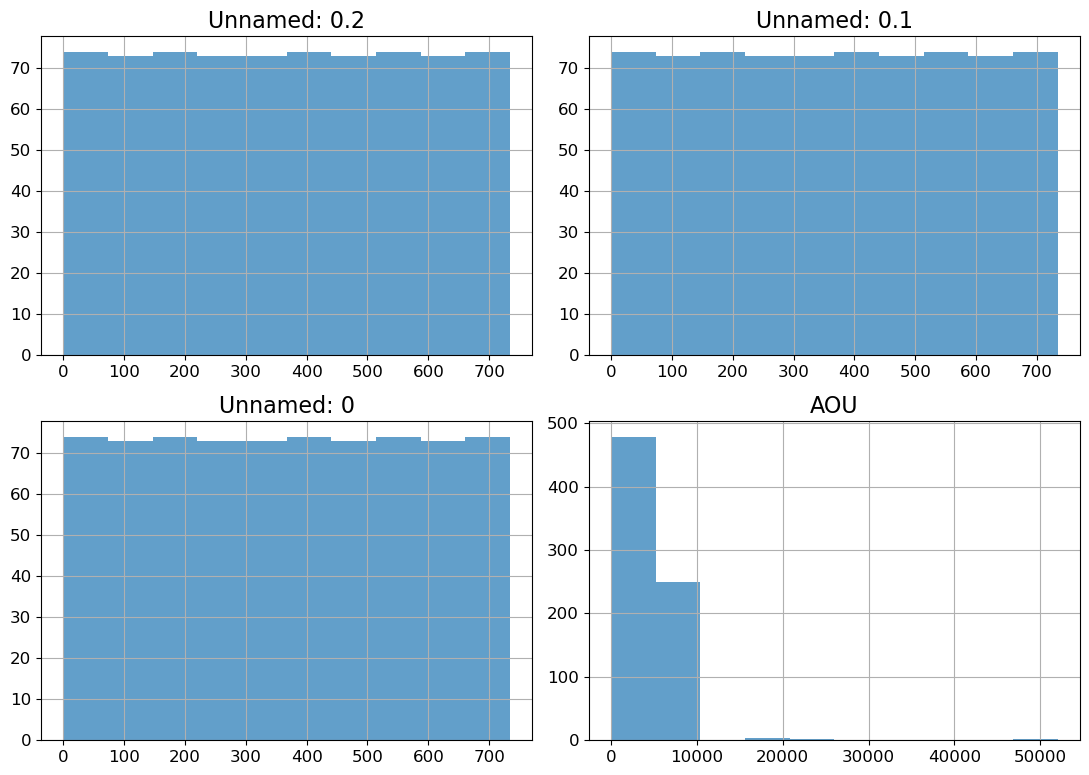

In [12]:
tmp = spp_summary.iloc[:,1:5]
tmp.rename(columns={'n_rutas':'Number of routes','first_year':'First year','last_year':'Last year','timeseries length':'Time series length'}, inplace=True)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))
tmp.hist(ax=axes, alpha=.7, density=False)
plt.suptitle('')
plt.tight_layout()

del tmp, fig, axes  

### Timeseries length distribution

- the frequency of timeseries length across all species.
- the number of routes per species and the length of their timeseries

Text(0.5, 0, 'Time series length (years)')

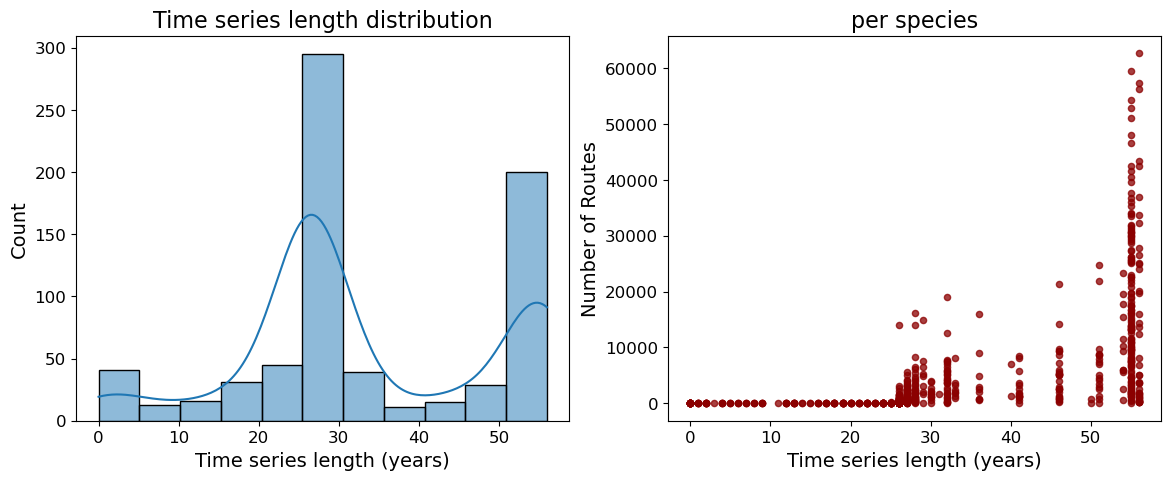

In [13]:

# Create a figure with 1 row and 2 columns of subplots

# Create the figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.histplot(data=spp_summary, x='timeseries length',kde=True, ax=axes[0])

spp_summary.plot.scatter(x='timeseries length', y='n_rutas', alpha=.75, ax=axes[1],color='darkred')
axes[0].set_title('Time series length distribution')
axes[0].set_xlabel('Time series length (years)')
axes[1].set_title('per species')
axes[1].set_ylabel('Number of Routes')
axes[1].set_xlabel('Time series length (years)')


In [14]:
# filtd = spp_summary[(spp_summary['first_year']>=1980) & (spp_summary['timeseries length']>=35) & (spp_summary['n_rutas']>=500)].sort_values(by=['timeseries length','n_rutas'],ascending=False)

# display(filtd)

Compute the fraction of years in which the species was sampled (out of the total number of years since the first year it was sampled).

We will create a new column `prct_years` in the `spp_summary` dataframe to store this information.

In [15]:
# aous = [4930,3160,7610,4980,5190,5930,4880,5810,6130,6882]
if ('spp_summary' in globals()) & ('prct_years' not in spp_summary.columns):
    prct = list()
    for i in spp_summary['AOU']:
        # name = get_spp_name(i,spps) # get species name
        yrs = Totals[Totals['AOU']==i]['Year'].drop_duplicates() # years found
        # prct = len(yrs) / (max(yrs)-min(yrs)) # fraction of years found
        if max(yrs)-min(yrs):  # if
            prct.append(len(yrs) / (max(yrs)-min(yrs)))
        else:
            prct.append(0.0)
        # print(name['spp'],'('+name['Common Name']+'):',prct)

    spp_summary['prct_years'] = prct
else:
    print("No need to compute the 'prct_years' column.")
    print("\t'spp_summary' already has 'prct_years' column!")




No need to compute the 'prct_years' column.
	'spp_summary' already has 'prct_years' column!


In [16]:
spp_summary.sort_values(by='prct_years',ascending=False,inplace=True)   
spp_summary[spp_summary['timeseries length']>=30]

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,AOU,n_rutas,first_year,last_year,timeseries length,English_Common_Name,French_Common_Name,Order,Family,Genus,Species,prct_years
43,234,234,98,98,1500,1925,1993,2023,30,Ring-necked Duck,Fuligule à collier,Anseriformes,Anatidae,Aythya,collaris,1.000000
238,238,238,269,269,3420,8172,1990,2023,33,Swainson's Hawk,Buse de Swainson,Accipitriformes,Accipitridae,Buteo,swainsoni,0.969697
240,239,239,571,571,6170,18960,1991,2023,32,Northern Rough-winged Swallow,Hirondelle à ailes hérissées,Passeriformes,Hirundinidae,Stelgidopteryx,serripennis,0.968750
239,240,240,725,725,7680,7772,1991,2023,32,Mountain Bluebird,Merlebleu azuré,Passeriformes,Turdidae,Sialia,currucoides,0.968750
241,241,241,407,407,4660,12669,1991,2023,32,Willow Flycatcher,Moucherolle des saules,Passeriformes,Tyrannidae,Empidonax,traillii,0.968750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,663,663,129,129,1870,1131,1967,2023,56,White-faced Ibis,Ibis à face blanche,Pelecaniformes,Threskiornithidae,Plegadis,chihi,0.482143
664,664,664,47,47,630,241,1967,2023,56,Gull-billed Tern,Sterne hansel,Charadriiformes,Laridae,Gelochelidon,nilotica,0.482143
658,662,662,83,83,1340,872,1967,2023,56,Mottled Duck,Canard brun,Anseriformes,Anatidae,Anas,fulvigula,0.482143
683,683,683,409,409,4665,31,1972,2022,50,unid. Alder Flycatcher / Willow Flycatcher,unid Moucherolle des aulnes / des saules,Passeriformes,Tyrannidae,Empidonax,alnorum / traillii,0.380000


We may isolate the passeriformes (order Passeriformes) with long overall time series.

In [17]:
# Passeriformes with longest time series and high fraction of years sampled
paseriformes_largos = spp_summary[(spp_summary['Order']=='Passeriformes') & (spp_summary['timeseries length']>=30)].sort_values(by='prct_years',ascending=False)
# aou_largos[['AOU',]]
paseriformes_largos.drop(columns=['Unnamed: 0','French_Common_Name','Order'],inplace=True)
paseriformes_largos.sort_values(by='prct_years',ascending=False)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,AOU,n_rutas,first_year,last_year,timeseries length,English_Common_Name,Family,Genus,Species,prct_years
240,239,239,571,6170,18960,1991,2023,32,Northern Rough-winged Swallow,Hirundinidae,Stelgidopteryx,serripennis,0.968750
239,240,240,725,7680,7772,1991,2023,32,Mountain Bluebird,Turdidae,Sialia,currucoides,0.968750
241,241,241,407,4660,12669,1991,2023,32,Willow Flycatcher,Tyrannidae,Empidonax,traillii,0.968750
244,246,246,677,7250,3957,1993,2023,30,Marsh Wren,Troglodytidae,Cistothorus,palustris,0.966667
245,243,243,580,6260,1697,1993,2023,30,Philadelphia Vireo,Vireonidae,Vireo,philadelphicus,0.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,647,647,531,5780,3550,1967,2023,56,Cassin's Sparrow,Passerellidae,Peucaea,cassinii,0.500000
642,653,653,470,5130,1863,1967,2023,56,Boat-tailed Grackle,Icteridae,Quiscalus,major,0.500000
656,656,656,540,5871,70,1972,2023,51,unid. Spotted Towhee / Eastern Towhee,Passerellidae,Pipilo,maculatus / erythrophthalmus,0.490196
683,683,683,409,4665,31,1972,2022,50,unid. Alder Flycatcher / Willow Flycatcher,Tyrannidae,Empidonax,alnorum / traillii,0.380000


In [18]:
if 'spp_summary' in globals():
    spp_summary.to_csv('spp_summaries.csv')
    print("spp_summary written to ./spp_summary.csv")

spp_summary written to ./spp_summary.csv


## We may look at a few species

The most abundant bird species in the U.S. can vary by region and year, but based on BBS data, some of the most consistently numerous species are:

### Top 10 Most Abundant Bird Species in the USA

| Rank | Common Name           | AOU   | Scientific Name           | Notes                                                                                   |
|------|-----------------------|-------|---------------------------|-----------------------------------------------------------------------------------------|
| 1    | European Starling     | 4930  | *Sturnus vulgaris*        | Non-native, introduced in the 19th century, now one of the most common birds.           |
| 2    | Mourning Dove         | 3160  | *Zenaida macroura*        | Widespread, found in many habitats including suburbs and farmlands.                      |
| 3    | American Robin        | 7610  | *Turdus migratorius*      | Familiar across the country, known for its red breast and presence in gardens.           |
| 4    | Red-winged Blackbird  | 4980  | *Agelaius phoeniceus*     | Abundant near wetlands, forms large flocks.                                              |
| 5    | House Finch           | 5190  | *Haemorhous mexicanus*    | Native to western U.S., now common in backyards nationwide.                              |
| 6    | Northern Cardinal     | 5930  | *Cardinalis cardinalis*   | Easily recognized, especially the male's vibrant red plumage.                            |
| 7    | American Crow         | 4880  | *Corvus brachyrhynchos*   | Highly adaptable and intelligent, found in rural and urban environments.                 |
| 8    | Song Sparrow          | 5810  | *Melospiza melodia*       | Wide distribution, known for its variety of songs.                                       |
| 9    | Barn Swallow          | 6130  | *Hirundo rustica*         | Long-distance migrant, often nests on human-made structures.                             |
| 10   | House Sparrow         | 6882  | *Passer domesticus*       | Introduced species, extremely abundant in urban and suburban areas.                      |

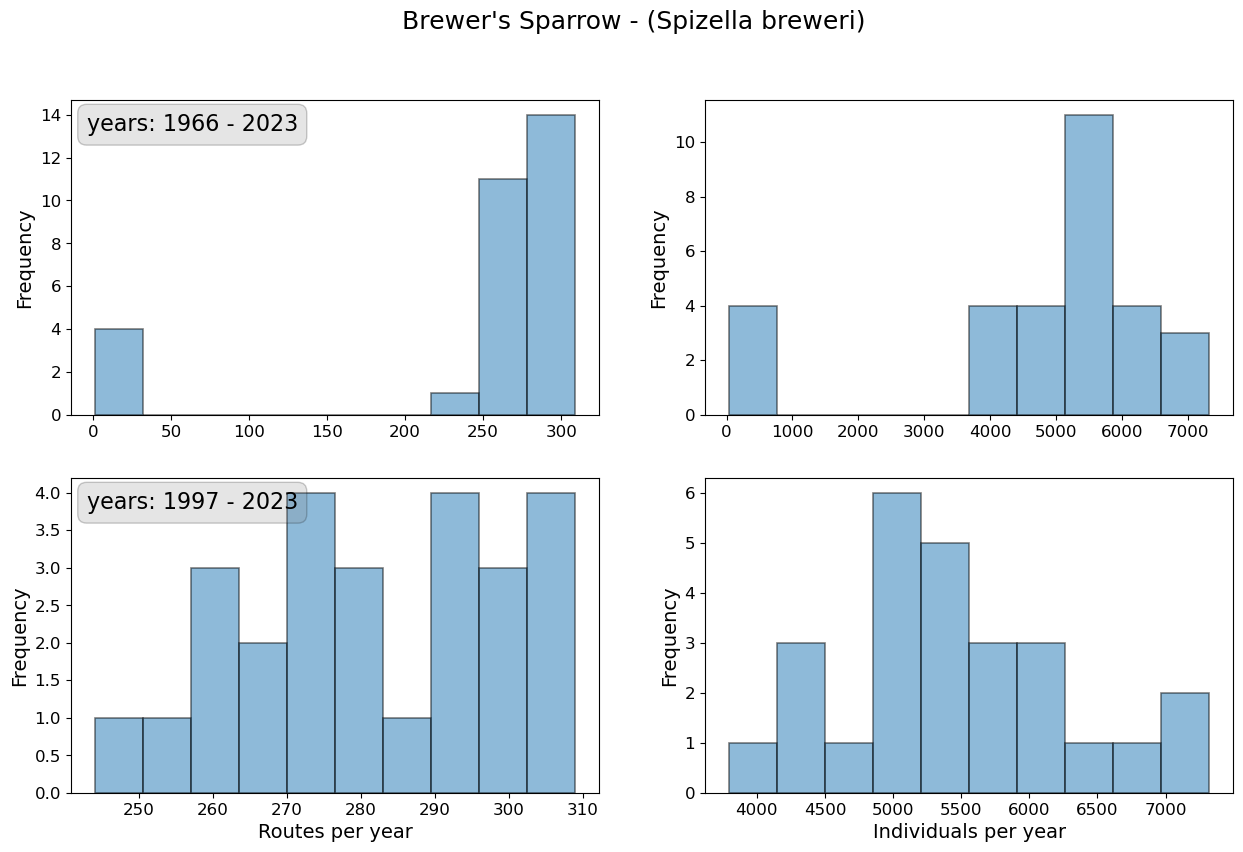

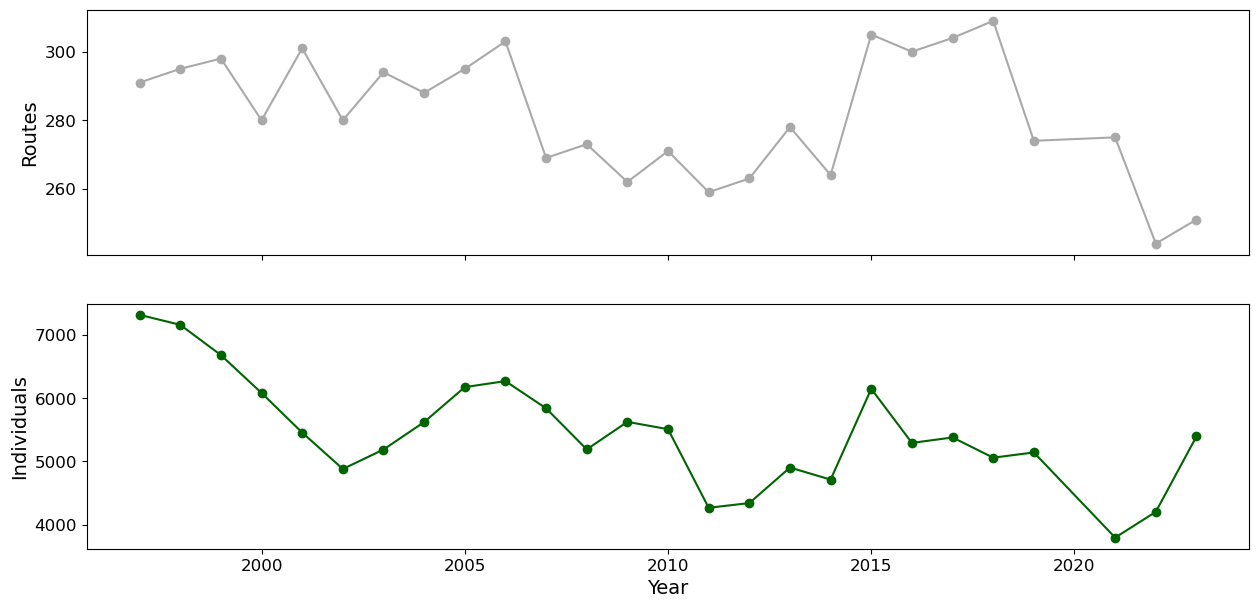

In [19]:
spp = 5620
sppname = get_spp_name(spp,spps)['Common Name']
sciname = get_spp_name(spp,spps)['spp']

# histograms of routes and individuals per year
fig, axs = plt.subplots( nrows=2,ncols=2, figsize=(15, 9))
Totals[(Totals['AOU']==spp) ][['Year','ruta']].groupby('Year').count().reset_index()['ruta'].plot.hist(
    density=False,alpha=.5,ax=axs[0,0], edgecolor='black', linewidth=1.2)
Totals[(Totals['AOU']==spp) ][['Year','Number of individuals']].groupby('Year').sum().reset_index()['Number of individuals'].plot.hist(density=False,alpha=.5,ax=axs[0,1], edgecolor='black', linewidth=1.2)

axs[0,0].text(0.03,0.9,"years: 1966 - 2023",fontsize=16, bbox=dict(facecolor='grey', alpha=0.2, boxstyle='round,pad=.4')
              ,transform = axs[0,0].transAxes)
axs[0,0].set_xlabel('');
axs[0,1].set_xlabel('');
fig.suptitle(sppname+' - ('+sciname+')')


Totals[(Totals['AOU']==spp) & (Totals['Year'] > 1996)][['Year','ruta']].groupby('Year').count().reset_index()['ruta'].plot.hist(
                                                                                                density=False,alpha=.5,ax=axs[1,0], edgecolor='black', linewidth=1.2)
Totals[(Totals['AOU']==spp) & (Totals['Year'] > 1996) ][['Year','Number of individuals']].groupby('Year').sum().reset_index()['Number of individuals'].plot.hist( 
                                                                                                density=False,alpha=.5,ax=axs[1,1], edgecolor='black', linewidth=1.2)

axs[1,0].text(0.03,0.9,"years: 1997 - 2023",fontsize=16, bbox=dict(facecolor='grey', alpha=0.2, boxstyle='round,pad=.4'),
              transform = axs[1,0].transAxes)
axs[1,0].set_xlabel('Routes per year')
axs[1,1].set_xlabel('Individuals per year')


# time series of routes and individuals per year
fig,axs = plt.subplots( nrows=2,ncols=1, figsize=(15, 7))
# Totals[(Totals['AOU']==spp) & (Totals['Year'] > 1996)][['Year','ruta']].groupby('Year').count()

Totals[(Totals['AOU']==spp) & (Totals['Year'] > 1996)][['Year','ruta']].groupby('Year').count().plot(
    kind='line', title='', linestyle='-', marker='o', legend='', color='darkgrey', ax=axs[0])

Totals[(Totals['AOU']==spp) & (Totals['Year']>1996)][['Year','Number of individuals']].groupby('Year').sum().plot(
    kind='line', linestyle='-', marker='o', legend='', color='darkgreen', ax=axs[1])
axs[1].set_ylabel('Individuals')
axs[0].set_ylabel('Routes')
axs[0].set_xlabel('')
_ = axs[0].set_xticklabels([]) # assign to nothing to avoid printing the text to the console

We will generate a figure for each species and save it to the `figs` directory. 

In [20]:
# do not  run unless you want to generate all figures (it takes time and resources!)
for i,r in spp_summary[['AOU','English_Common_Name']].iterrows():
    spp = r['AOU']
    sppname = r['English_Common_Name']
    plot_ts_routests(spp,sppname,Totals,spp_summary,plotit=False)


saving AOU: 660 to: figs/660routes+tts.png
saving AOU: 2620 to: figs/2620routes+tts.png
saving AOU: 5078 to: figs/5078routes+tts.png
saving AOU: 20630 to: figs/20630routes+tts.png
saving AOU: 52021 to: figs/52021routes+tts.png
saving AOU: 2400 to: figs/2400routes+tts.png
saving AOU: 2220 to: figs/2220routes+tts.png
saving AOU: 1580 to: figs/1580routes+tts.png
saving AOU: 1570 to: figs/1570routes+tts.png
saving AOU: 7421 to: figs/7421routes+tts.png
saving AOU: 6686 to: figs/6686routes+tts.png
saving AOU: 900 to: figs/900routes+tts.png
saving AOU: 6883 to: figs/6883routes+tts.png
saving AOU: 6880 to: figs/6880routes+tts.png
saving AOU: 3826 to: figs/3826routes+tts.png
saving AOU: 6380 to: figs/6380routes+tts.png
saving AOU: 6370 to: figs/6370routes+tts.png
saving AOU: 6340 to: figs/6340routes+tts.png
saving AOU: 6121 to: figs/6121routes+tts.png
saving AOU: 6230 to: figs/6230routes+tts.png
saving AOU: 6200 to: figs/6200routes+tts.png
saving AOU: 3095 to: figs/3095routes+tts.png
saving AOU

# Maps

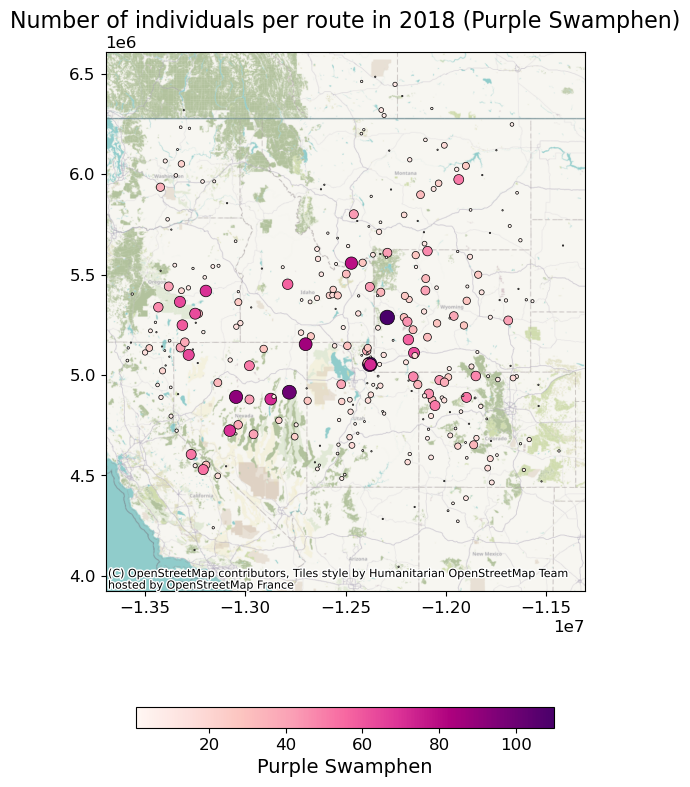

In [21]:
import geopandas as gpd
import contextily as ctx
spp = 5620

yr  = 2018 # Plot the number of individuals per route for the specified species in 2022

subTotals = Totals[Totals['AOU']==spp][['Year','ruta','Longitude','Latitude','Number of individuals']]
# Totals.columns
geototals = gpd.GeoDataFrame(
    subTotals, geometry=gpd.points_from_xy(subTotals.Longitude, subTotals.Latitude), crs="EPSG:4326"
)


geototals = geototals.to_crs(epsg=3857)

# ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax = geototals[geototals['Year']==yr].plot('Number of individuals', cmap='RdPu',  markersize='Number of individuals', ec='k',lw=0.5,
                                             legend=True,
                                             legend_kwds={'shrink': 0.45,'label':sppname,'orientation': 'horizontal'},  # Adjust the shrink value (e.g., 0.5 for 50%)
                                             figsize=(12, 10)
                                             )
# cbar = plt.colorbar(shrink=0.75)
ax.set_title('Number of individuals per route in '+str(yr)+' ('+sppname+')')
ctx.add_basemap(ax)



# Writing data to a dictionary

The dictionary is organized as follows:

- key: (species, routeID)
- value: [(year, abundance)] 

routeID is composed by joining 'Country Number' `Totals['CountryNum'].astype(str)`, 'State Number' `Totals['StateNum'].astype(str)`, and 'Route Number' `Totals['Route'].astype(str)`

We will pad the timeseries, starting in 1966 with 0s for those years in which birds were not counted

In [25]:
first_year = 1966
last_year = 2024

totals_dict = {}

# Group the DataFrame by 'Year' and 'RouteDataID'
# Then iterate through each group
for (aou, route_id), group_df in Totals.groupby(['AOU', 'ruta']):
        # Extract the 'Totals' column for the current group and convert it to a list
        totals_list = list(zip(group_df['Year'].tolist(), group_df['Number of individuals'].tolist()))
        # Add the (spp, route_id) tuple as key and the list of totals as value to the dictionary
        totals_dict[(str(aou), str(route_id))] = fill_missing_year_data(totals_list, first_year, last_year)   #totals_list

We may now extract the data by parsing the dictionary. 

Here are a couple functions that will:

- generate a pandas DataFrame for a given species with routeID as columns and years as rows
- for a given routeID, species as columns and years as rows
- for a given year, species as columns and routes rows

you may then export this to a csv if needed

**Examples**

- species: '7250'  -- Marsh Wren (_Aechmophorus,occidentalis_)


In [23]:
print('An example entry in totals_dict')
print('-------------------------------')

s = get_spp_name(spp,spps)
print(str(spp)+':',s['Common Name'],"("+ s['spp']+")")

species_df = species_to_df(str(spp),totals_dict)
print("no. routes:", species_df.shape[1])

print("\nAbundance matrix (years x routes):")
print("--------------------------------")
display(species_df)

An example entry in totals_dict
-------------------------------
5620: Brewer's Sparrow (Spizella breweri)
no. routes: 711

Abundance matrix (years x routes):
--------------------------------


Route,1240401,1240406,1240407,12404101,12404103,12404106,12404107,12404114,1240419,12404201,...,8409287,8409288,8409290,84092901,84092902,8409293,8409296,8409297,8409298,8409299
Year,,,,,,,,,,,,,,,,,,,,,
1966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
datos = dict()
for i in spps['AOU'].drop_duplicates():
    datos[i] = species_to_df(str(i),totals_dict)


0      1770
1      1780
2      1760
3      1690
4      1691
       ... 
758    5980
759    5986
760    6000
761    6010
762    6040
Name: AOU, Length: 763, dtype: int64

# Number of years sampled for routes 
We may also get the total number of years the species was observed per route

In [24]:
# We sum rows over the boolean matrix (species_df>0)
samples = pd.DataFrame((species_df>0).sum(axis=0).sort_values(ascending=False),columns=['No. years with observations'])
# display(samples)


### Plot the number of years sampled per route
Lets first merge with routes to get lat/lon in formation and plot the routes with longest observations

In [25]:
merged_samples = samples.merge(routes[['Latitude','Longitude','ruta']], left_on='Route', right_on='ruta', how='left')
display(merged_samples.head())      

,No. years with observations,Latitude,Longitude,ruta
0,26,44.722359,-113.520360,8403314
1,26,45.034109,-113.562483,8403310
2,26,37.181085,-105.745965,8401755
3,26,42.331156,-114.279453,8403325
4,26,43.549349,-113.009455,84033902


We may see which locations contain the largest number of years with observations for a given species.

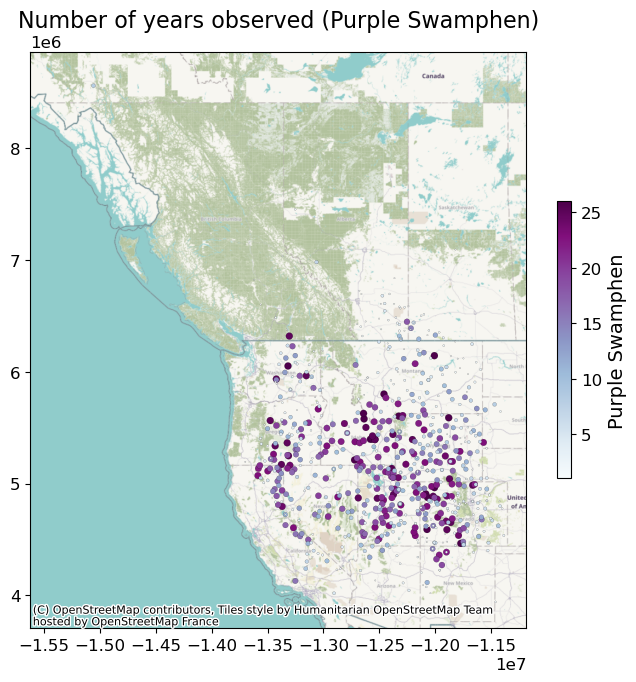

In [26]:
samples_geo = gpd.GeoDataFrame(
            merged_samples, geometry=gpd.points_from_xy(merged_samples.Longitude, merged_samples.Latitude), crs="EPSG:4326"
            )   
samples_geo = samples_geo.to_crs(epsg=3857)

ax = samples_geo.plot('No. years with observations', cmap='BuPu',  markersize='No. years with observations', ec='k',lw=0.1,
                                             legend=True,
                                             legend_kwds={'shrink': 0.45,'label':sppname,'orientation': 'vertical'},  # Adjust the shrink value (e.g., 0.5 for 50%)
                                             figsize=(8, 8)
                                             )
ax.set_title('Number of years observed ('+sppname+')')
ctx.add_basemap(ax)



We could also see the distribution of the number of years sampled across all routes.

In [27]:
# .sum(axis=0) counts the number of years with observations per route
n_route_by_sizes = list()
for i in range(15,2023-1966):
    n_route_by_sizes.append(((species_df>0).sum(axis=0) > i).sum())

# n_route_by_sizes

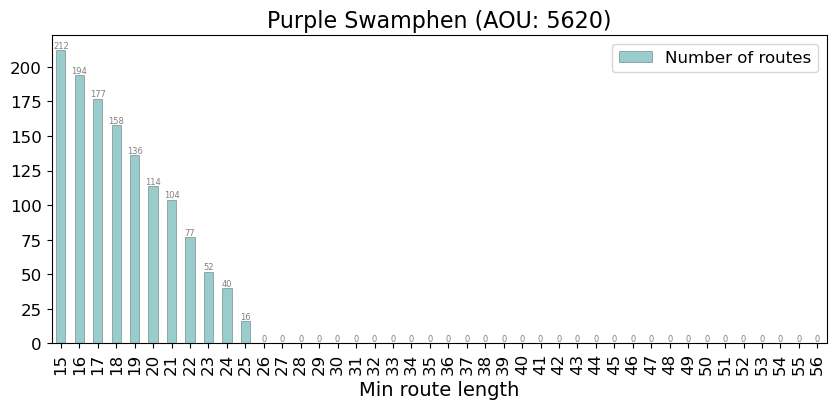

In [28]:
ax = pd.DataFrame(zip(range(15,100),n_route_by_sizes),columns=['Min route length','Number of routes']).plot.bar(
    x='Min route length',
    y='Number of routes',
    figsize=(10,4),
    alpha=0.4, color='Teal',lw=.5,ec='black'
    )   
ax.set_title(sppname+' (AOU: '+str(spp)+')')
ax.bar_label(ax.containers[0], label_type='edge',fontsize=6,color='grey');


## Number of years sampled per route across all species

In [29]:
# totals_dict
species_to_df(str(spp),totals_dict).sum(axis=0).sort_values(ascending=False).head(1).index.tolist()[0]

'84069254'

In [46]:
totals_dict[str(spp),species_to_df(str(spp),totals_dict).sum(axis=0).sort_values(ascending=False).head(1).index.tolist()[0]]

[(1966, 0),
 (1967, 0),
 (1968, 0),
 (1969, 0),
 (1970, 0),
 (1971, 0),
 (1972, 0),
 (1973, 0),
 (1974, 0),
 (1975, 0),
 (1976, 0),
 (1977, 0),
 (1978, 0),
 (1979, 0),
 (1980, 0),
 (1981, 0),
 (1982, 0),
 (1983, 0),
 (1984, 0),
 (1985, 0),
 (1986, 0),
 (1987, 0),
 (1988, 0),
 (1989, 0),
 (1990, 0),
 (1991, 0),
 (1992, 0),
 (1993, 0),
 (1994, 0),
 (1995, 0),
 (1996, 0),
 (1997, 116),
 (1998, 163),
 (1999, 79),
 (2000, 147),
 (2001, 132),
 (2002, 118),
 (2003, 94),
 (2004, 181),
 (2005, 156),
 (2006, 181),
 (2007, 124),
 (2008, 85),
 (2009, 81),
 (2010, 93),
 (2011, 80),
 (2012, 93),
 (2013, 105),
 (2014, 68),
 (2015, 53),
 (2016, 78),
 (2017, 0),
 (2018, 59),
 (2019, 20),
 (2020, 0),
 (2021, 42),
 (2022, 26),
 (2023, 75),
 (2024, 0)]

In [ ]:
# species_df[species_df.lt(0)]#.loc[species_df.index > 1996].sum(axis=0)
the_longest = {}
for i in paseriformes_largos['AOU'].drop_duplicates(): 
    kk = species_to_df(str(i),totals_dict) > 0
    d = kk.sum(axis=0).sort_values(ascending=False).head(1)
    tmp = d.tolist()[0]
    if tmp > 27:
        # print('processing',get_spp_name(i,spps)['Common Name'])
        # print(totals_dict[str(i),d.index.tolist()[0]])
        the_longest['AOU'] = i
        the_longest['Route'] = d.index.tolist()[0]
        the_longest['No. years'] = totals_dict[str(i),d.index.tolist()[0]]
        the_longest['Common Name'] = get_spp_name(i,spps)['Common Name']
        the_longest['spp'] = get_spp_name(i,spps)['spp']
        # the_longest[(i,d.index.tolist()[0])] = totals_dict[str(i),d.index.tolist()[0]]

# the_longest.to_csv('the_longest_timeseries.csv',index=False)

In [44]:
(pd.Series([i[1] for i in the_longest['timeseries']])>0).sum()

np.int64(28)

# Generate webpage
We will generate a webpage with the summary data to better visualize an aggregated abundance across all routes in the US 

In [27]:
generate_species_webpage('spp_summaries.csv','figs/')

Removed 'Unnamed: 0' column.
Webpage 'species_webpage.html' generated successfully!


# Relevant Timeseries

- timeseries of route starting after 1980
- timeseries with at least 35 years of data
- species with at least 500 routes

This yields a total of 25 species.

In [113]:
spp_summary['AOU'].tolist()

[2620,
 20630,
 660,
 52021,
 5078,
 1580,
 2220,
 2400,
 1570,
 7421,
 6686,
 900,
 1910,
 2030,
 4570,
 5275,
 5390,
 3990,
 5360,
 4080,
 2721,
 2720,
 2560,
 2740,
 2810,
 4010,
 3950,
 3960,
 2070,
 2190,
 5470,
 5491,
 5500,
 4022,
 4030,
 2000,
 1782,
 1410,
 1590,
 1460,
 1480,
 4530,
 4550,
 1500,
 1800,
 4140,
 5650,
 5660,
 3480,
 3560,
 6440,
 6390,
 6685,
 6580,
 6510,
 6500,
 6900,
 6960,
 6690,
 6700,
 6630,
 2460,
 6180,
 6292,
 6380,
 6370,
 6340,
 6121,
 6230,
 6200,
 3095,
 3050,
 2510,
 3730,
 2540,
 6300,
 6330,
 3290,
 3700,
 3190,
 3470,
 3200,
 3732,
 3620,
 3650,
 3670,
 3680,
 3780,
 3790,
 5730,
 5739,
 5740,
 3180,
 5920,
 5935,
 5800,
 2930,
 2950,
 6090,
 4040,
 4060,
 5677,
 5690,
 5570,
 5590,
 2860,
 2650,
 2230,
 5750,
 5760,
 640,
 650,
 5900,
 6000,
 5940,
 3010,
 2980,
 2971,
 2970,
 3100,
 6100,
 3020,
 3210,
 7460,
 634,
 7621,
 4691,
 7222,
 7150,
 7300,
 4679,
 3460,
 3270,
 3280,
 5860,
 3410,
 3451,
 3340,
 3350,
 3400,
 5910,
 7060,
 4813,
 4

In [ ]:
# print('AOU:',filtd['AOU'].tolist()[1])
print(filtd.iloc[1,:])
kk = species_to_df(str(filtd['AOU'].tolist()[1]),totals_dict).T
display(kk)

AOU: 3310
AOU                                 3310
n_rutas                             8439
first_year                          1982
last_year                           2023
timeseries length                     41
English_Common_Name     Northern Harrier
French_Common_Name     Busard des marais
Order                    Accipitriformes
Family                      Accipitridae
Genus                             Circus
Species                        hudsonius
Name: 258, dtype: object


Year,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Route,,,,,,,,,,,,,,,,,,,,,
1241110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1241111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12411137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1241116,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1241117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84092901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8409293,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,3,1,0
8409296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.merge(kk,routes[['ruta','Latitude','Longitude']],left_index=True,right_on='ruta',how='left')
# kk.index
# routes.columns

,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,...,2018,2019,2020,2021,2022,2023,2024,ruta,Latitude,Longitude
638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1241110,49.294880,-121.688470
639,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1241111,49.184020,-122.534780
710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12411137,60.001790,-134.660260
644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1241116,50.239270,-115.874490
645,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1241117,50.924350,-116.478390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,84092901,44.771872,-110.457771
5719,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,1,0,8409293,41.265669,-110.263694
5721,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8409296,41.657303,-109.224754
5722,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,8409297,41.569733,-109.183578


In [ ]:
dir = 'output/'

names = {}
for i in filtd['AOU'].tolist():
    # print('[ Processing ] AOU:',i)
    # print(spps[spps['AOU']==i][['AOU','English_Common_Name','Order','Family','Genus','Species']].values.tolist())
    names[i] = spps[spps['AOU']==i][['English_Common_Name','Order','Family','Genus','Species']].values.tolist()
    tmp = species_to_df(str(i),totals_dict).T
    pd.merge(tmp,routes[['ruta','Latitude','Longitude']],left_index=True,right_on='ruta',how='left').to_csv(dir+'species_'+str(i)+'.csv')



flattened_data_dict = {k: v[0] for k, v in names.items()}

names = pd.DataFrame.from_dict(flattened_data_dict,orient='index').reset_index()
names.columns = ['AOU','English_Common_Name','Order','Family','Genus','Species']

names.to_csv(dir+'species_names.csv',index=False)

# Relevant routes

We will define a relevant route as having:
- a set of long time series, that is, with spp that have been well surveyed
- with species having timeseries with continuous presence (few zeros)
- Mostly passeriformes  

In [10]:
# print("Original DataFrame head:")
# print(Totals.head())
print("\nOriginal DataFrame info:")
Totals.info()



Original DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3849449 entries, 0 to 3849448
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   RouteDataID            int64  
 1   CountryNum             int64  
 2   StateNum               int64  
 3   Route                  int64  
 4   RPID                   int64  
 5   Year                   int64  
 6   AOU                    int64  
 7   Number of individuals  int64  
 8   ruta                   object 
 9   RouteName              object 
 10  Active                 int64  
 11  Latitude               float64
 12  Longitude              float64
 13  Stratum                int64  
 14  BCR                    int64  
 15  RouteTypeID            int64  
 16  RouteTypeDetailID      int64  
dtypes: float64(2), int64(13), object(2)
memory usage: 499.3+ MB


## Filter the data for quality and relevant years ---
The `abundance_col` argument should match the name of your abundance column.

Common names are `Number of individuals`, `SpeciesTotal`, or simply `count`.


In [11]:
Totals[['AOU','ruta','Year','Number of individuals','Latitude','Longitude']].head()

,AOU,ruta,Year,Number of individuals,Latitude,Longitude
0,1320,1241101,1997,9,48.78529,-123.59913
1,1720,1241101,1997,32,48.78529,-123.59913
2,2300,1241101,1997,1,48.78529,-123.59913
3,2730,1241101,1997,1,48.78529,-123.59913
4,2940,1241101,1997,8,48.78529,-123.59913


In [12]:
abundance_column_name = 'Number of individuals'

filtered_df = filter_bbs_data(Totals, abundance_col=abundance_column_name,first_yr=1991)

print("\nFiltered DataFrame head:")
display(filtered_df)
# print("\nFiltered DataFrame info:")
# filtered_df.info()



Initial rows: 3849449
After filtering Year >= 1991: 3848664 rows
After excluding 2020: 3848664 rows
After filtering RPID == 101: 3824614 rows
After excluding specific AOU codes: 3809771 rows

Filtered DataFrame head:


,RouteDataID,CountryNum,StateNum,Route,RPID,Year,AOU,Number of individuals,ruta,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID
0,6227579,124,11,1,101,1997,1320,9,1241101,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
1,6227579,124,11,1,101,1997,1720,32,1241101,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
2,6227579,124,11,1,101,1997,2300,1,1241101,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
3,6227579,124,11,1,101,1997,2730,1,1241101,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
4,6227579,124,11,1,101,1997,2940,8,1241101,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3849444,6381048,840,80,901,101,2023,7290,3,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
3849445,6381048,840,80,901,101,2023,7310,48,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
3849446,6381048,840,80,901,101,2023,7360,42,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
3849447,6381048,840,80,901,101,2023,7510,16,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2


In [13]:
filtered_df['Year'].describe()

count    3.809771e+06
mean     2.009660e+03
std      7.614031e+00
min      1.991000e+03
25%      2.003000e+03
50%      2.010000e+03
75%      2.016000e+03
max      2.023000e+03
Name: Year, dtype: float64

## Calculate species presence metrics

Adjust `presence_threshold` as needed. 0.8 means a species must be present in at least 80% of the years the route was surveyed.


In [14]:

species_presence_results = calculate_species_presence(
    filtered_df,
    abundance_col='Number of individuals',
    presence_threshold=0.9
)

print("\nSpecies Presence Results head:")
display(species_presence_results)



Calculating species presence metrics...


Calculated presence metrics for 400886 species-route combinations.

Species Presence Results head:


,ruta,AOU,total_survey_years_for_route,years_with_presence,presence_ratio,is_continuously_present
0,1240401,510,6,1,0.166667,False
1,1240401,530,6,4,0.666667,False
2,1240401,534,6,4,0.666667,False
3,1240401,540,6,6,1.000000,True
4,1240401,590,6,6,1.000000,True
...,...,...,...,...,...,...
400881,8409299,6882,2,1,0.500000,False
400882,8409299,7020,2,2,1.000000,True
400883,8409299,7150,2,2,1.000000,True
400884,8409299,7610,2,2,1.000000,True


In [ ]:
# species_presence_results

# # Filter for only continuously present species
# continuous_species_on_routes = species_presence_results[
#     species_presence_results['is_continuously_present'] == True
# ].copy()

# continuous_species_on_routes.groupby('ruta').size().reset_index(name='num_continuous_species')

# continuous_species_on_routes.groupby('ruta').size().reset_index(name='num_continuous_species')

## Identify the top routes with longest time series of continuous species sample
Adjust `top_n_routes` to see more or fewer top routes.

In [15]:

top_quality_routes = identify_long_timeseries_routes(filtered_df, species_presence_results)

print("\nTop Routes with Longest Time Series of Continuously Present Species:")

display(top_quality_routes.sort_values(by=['num_survey_years','num_continuous_species'],ascending=False))



Identifying routes with longest time series of continuously present species...



Top Routes with Longest Time Series of Continuously Present Species:


,ruta,num_continuous_species,min_year,max_year,num_survey_years,Latitude,Longitude
1264,84063903,36,1995,2023,28,34.730060,-76.935921
82,8407235,55,1996,2023,27,41.228900,-76.456000
117,84072132,53,1996,2023,27,41.546735,-76.962825
143,8407229,51,1996,2023,27,41.312139,-76.663816
144,8407234,51,1996,2023,27,41.441090,-76.907340
...,...,...,...,...,...,...,...
3913,8401463,18,1997,1997,1,35.818032,-117.342044
3914,8409280,18,2012,2012,1,42.872871,-107.524437
4102,8409298,16,2001,2001,1,41.889976,-108.840195
4394,84006106,12,1997,1997,1,35.866379,-114.661987


Use `top_quality_routes` for further analysis, mapping, or reporting.

For example, to get just the route IDs:

In [19]:
n_routes=15
print("\nRoute IDs of top quality routes:")
top_quality_routes.sort_values(by=['num_survey_years','num_continuous_species'],ascending=False,inplace=True)
top_quality_routes['ruta'].iloc[:n_routes]
# print(top_quality_routes['ruta'].tolist())




Route IDs of top quality routes:


1264    84063903
82       8407235
117     84072132
143      8407229
144      8407234
249      8407236
296     84014153
341      8401498
898     12476306
1010     8405920
1265     8408823
1521    12445101
1656     8408919
2104     8408943
2544     1247604
Name: ruta, dtype: object

To get the full data for a specific top route:
    


In [ ]:
# # example_top_route = top_quality_routes.iloc[0]['ruta']
# # data_for_example_route = filtered_df[filtered_df['ruta'] == example_top_route]
# # print(f"\nData for top route {example_top_route}:")
# # print(data_for_example_route.head())

# # top_quality_routes['ruta'].iloc[0]
# It's more efficient to cast the 'AOU' column once before the loop
spps_casted = cast_columns_to_str(spps, ['AOU'])

# A list to hold the DataFrame for each route
all_routes_data = []

# Loop through each route in the 'ruta' column of your top_quality_routes DataFrame
for la_ruta in top_quality_routes['ruta']:
    print(f"Processing route: {la_ruta}...")
    
    # Create the species-by-year DataFrame for the current route
    rts = route_to_df(str(la_ruta), totals_dict) # Ensure la_ruta is a string if keys are strings
    
    # Skip routes that have no data in the totals_dict
    if rts.empty:
        print(f"  - No data for route {la_ruta}, skipping.")
        continue

    # Calculate the number of years each species was observed
    rts_length = pd.DataFrame((rts > 0).sum(axis=0).sort_values(ascending=False))
    rts_length.reset_index(inplace=True)
    rts_length.rename(columns={'index': 'Species', 0: 'yrs with observations'}, inplace=True)
    
    # Cast the 'Species' (AOU) column to string for the merge
    rts_length['Species'] = rts_length['Species'].astype(str)

    # Merge with species information
    s = rts_length.merge(
        spps_casted, 
        left_on='Species', 
        right_on='AOU'
    )[['AOU', 'English_Common_Name', 'Order', 'Genus', 'Species_y', 'yrs with observations']]

    # Merge with the abundance data (years as columns)
    # Transpose rts so that species (AOU) is the index for merging
    d = s.merge(rts.T, right_index=True, left_on='AOU', how='left')
    
    # Filter for species with a significant observation history
    d = d[d['yrs with observations'] > 27]
    # Add the route identifier to the DataFrame
    d['ruta'] = la_ruta

    
    # d = d.insert(loc=0, column='ruta', value=la_ruta)  # Move 'ruta' to the first column
    # d.insert(loc=1, column='Longitude', value=la_ruta, inplace=True)  # Move 'ruta' to the first column
    # d.insert(loc=0, column='ruta', value=la_ruta, inplace=True)  # Move 'ruta' to the first column

    # Add the resulting DataFrame to our list
    all_routes_data.append(d)

# Concatenate all the individual DataFrames into one large DataFrame
final_df = pd.concat(all_routes_data, ignore_index=True)

# Add the route's geographic information
final_df = final_df.merge(routes[['ruta','Latitude','Longitude']], on='ruta', how='left')

# Display the head of the final combined DataFrame
final_df.to_csv('final_routes_data.csv', index=False)



Processing route: 84063903...
Processing route: 8407235...


Processing route: 84072132...
Processing route: 8407229...
Processing route: 8407234...
Processing route: 8407236...
Processing route: 84014153...
Processing route: 8401498...
Processing route: 12476306...
Processing route: 8405920...
Processing route: 8408823...
Processing route: 12445101...
Processing route: 8408919...
Processing route: 8408943...
Processing route: 1247604...
Processing route: 8405325...
Processing route: 8405326...
Processing route: 8404643...
Processing route: 8402103...
Processing route: 84063101...
Processing route: 8404642...
Processing route: 8406302...
Processing route: 8403538...
Processing route: 8406310...
Processing route: 84072192...
Processing route: 8408842...
Processing route: 8403925...
Processing route: 8401471...
Processing route: 8406324...
Processing route: 8406149...
Processing route: 8408225...
Processing route: 8403535...
Processing route: 8403909...
Processing route: 8405256...
Processing route: 8408226...
Processing route: 8404606...
Processi

In [127]:
final_df.ruta



0        84063903
1        84063903
2        84063903
3        84063903
4        84063903
           ...   
10603    84083347
10604    84083347
10605    84083347
10606    84083347
10607    84083347
Name: ruta, Length: 10608, dtype: object

In [115]:
rts.T.values.tolist()

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [100]:
rts.to_dict(orient='list')


{'580': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0],
 '650': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0],
 '1180': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 '1200': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  